Click to launch an interactive version of this notebook

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/gschivley/pudl_examples/HEAD?urlpath=%2Fdoc%2Ftree%2Fhydro_ramp_rates.ipynb)

# Calculating hydro ramp rates for capacity expansion models

## Background
A common way to represent hydroelectric generation in capacity expansion models is as a single resource per region with generation constrained around the historical (monthly) capacity factor. This approach simplifies the modeling process and ensures that seasonal hydro profiles match a historically appropriate weather year. GenX uses the historical capacity factors as a proxy for inflow, allowing the hydro resource to shift generation within a modeling period, given constraints of reservoir size (energy to power ratio) and ramp rate. While hydroelectric plants can ramp up and down quickly, they are often constrained by environmental regulations, operational practices, and other non-grid requirements.

When all hydro capacity within a region is represented as a single resource the allowable ramp rates are likely lower than they would be for individual plants. Therefore, it is important to set realistic ramp rate constraints in capacity expansion models to ensure that the modeled hydro resources are not overly flexible.

## Method
As proposed by [Marshall and Grubert](https://onlinelibrary.wiley.com/doi/abs/10.1029/2021EF002503), historical ramp rates can be calculated using EIA 930 hourly generation by source within different balancing authorities (BAs). Something like the 5th or 10th percentile of the observed ramp up/down rates can be used as a constraint in GenX.

The GenX constraint is expressed as a fraction of capacity. Ramp rates (MW/hr) need to be normalized by installed capacity within each BA.

## Difficulties and potential issues
- EIA data has generation by BA from 2015-present. They publish a file with the [BA and capacity of each plant](https://www.eia.gov/electricity/930-content/EIA_930A_2023_with%20layout.xlsx) (2023 vintage), but BAs can change over time. Capacity from 2015-present has also changed some over that period.
- Until some time in 2024, reported hydro generation always included pumped hydro. In 2024-present, EIA started to also report "hydro_excluding_pumped_storage" and "pumped_storage". The combined hydro/pumped hydro generation is possibly a problem in BAs with large pumped hydro capacity (relative to conventional hydro). We have a far longer timeseries of the combined data, which would (could?) give more variability. The first table below shows BAs where >10% of total capacity is pumped hydro (average capacity of each technology from 2015-present).
- The second table includes the number of sequential hours (two or more hours) that include both hydro without pumped storage and pumped storage. I found that DUK seems to include pumped storage in their "without pumped storage" numbers in some hours, so it's best to only include hours where both values are reported[^1].
- There are estimates of streamflow out of dams (Dayflow and ResOpUS) but the processed sources report at daily resolution.

## Method details
### Regions without large pumped hydro fraction
Use the full timeseries of hourly data to calculate hourly ramp rates. Divide the ramps by capacity (MW) installed in each year.

### Regions with large pumped hydro fraction and good tech split
This is regions that report both pumped and conventional hydro in the same hours. See the second table below. There are many fewer hours available, so maybe take more extreme values?

One thought... if I use a return value rather than percentile, maybe it's possible to connect the return period length with the amount of time available.

### Regions with large pumped hydro fraction and bad data
These regions have significant pumped hydro and always report it combined with conventional hydro. There's no good way to separate. Ramp rates could be calculated combined and just note. Or a separate region could be used as a proxy.

The worst region is PJM (3.3 GW conventional, 5 GW pumped storage). Other large capacity regions in this category include NYIS, CISO, and MISO. But since these are also large BAs, the relative error from hydro ramp rate is probably quite small.


**Fraction of total hydro capacity from storage**

| balancing_authority_code_eia   |   Conventional Hydroelectric |   Hydroelectric Pumped Storage |   storage_fraction |
|:-------------------------------|-----------------------------:|-------------------------------:|-------------------:|
| PSCO                           |                      56.2083 |                        300     |           0.842204 |
| LDWP                           |                     325.733  |                       1626.9   |           0.833183 |
| SCEG                           |                     255.067  |                        574.533 |           0.692543 |
| DUK                            |                    1181.83   |                       2198     |           0.650328 |
| SRP                            |                      92.6    |                        154.1   |           0.624645 |
| PJM                            |                    3296.39   |                       5079.47  |           0.606441 |
| AECI                           |                      30      |                         31     |           0.508197 |
| MISO                           |                    2399.8    |                       2415.8   |           0.501661 |
| ISNE                           |                    1903.93   |                       1739.5   |           0.477434 |
| SOCO                           |                    3310.1    |                       1306.6   |           0.283016 |
| TVA                            |                    4871.59   |                       1808.6   |           0.270741 |
| CISO                           |                    6705.4    |                       2097.9   |           0.238308 |
| SEPA                           |                    1081.9    |                        328     |           0.232641 |
| WACM                           |                     702.867  |                        208.5   |           0.228777 |
| NYIS                           |                    4681.32   |                       1240     |           0.209413 |


**Number of sequential hours hydro without pumped storage is reported**
| Balancing Authority   |   Sequential Hours |
|:----------------------|-------------------:|
| DUK                   |               3311 |
| ISNE                  |               6404 |
| LDWP                  |               4604 |
| SOCO                  |               5109 |
| TVA                   |               3455 |


[^1]: DUK has conventional hydro capacity of 1.1 GW and >2 GW pumped storage. Hourly values for hydro without pumped storage go up to ~3GW, indicating that it probably includes the pumped storage.

In [1]:
import pandas as pd
import duckdb

In [2]:
con = duckdb.connect()

In [3]:
# Download plant/BA relationship
s = """
SELECT
    plant_id_eia,
    report_date,
    balancing_authority_code_eia,

FROM 's3://pudl.catalyst.coop/nightly/core_eia860__scd_plants.parquet'

WHERE report_date >= '2014-01-01'
"""
# WHERE data_maturity in ('final', 'provisional')
plant_ba = con.execute(s).fetchdf()
plant_ba["year"] = plant_ba["report_date"].dt.year
plant_ba = plant_ba.drop_duplicates(subset=["plant_id_eia", "year", "balancing_authority_code_eia"])


In [4]:
plant_ba

,plant_id_eia,report_date,balancing_authority_code_eia,year
0,69070,2025-01-01,MISO,2025
1,69069,2025-01-01,PJM,2025
2,69068,2025-01-01,CISO,2025
3,69067,2025-01-01,NYIS,2025
4,69065,2025-01-01,NYIS,2025
...,...,...,...,...
148572,8,2014-01-01,SOCO,2014
148573,7,2014-01-01,SOCO,2014
148574,4,2014-01-01,SOCO,2014
148575,3,2014-01-01,SOCO,2014


In [7]:
# Excel file posted with 930 data, don't need to use now that we have the data above

# url = "https://www.eia.gov/electricity/930-content/EIA_930A_2023_with%20layout.xlsx"
# _plant_ba = pd.read_excel(url, sheet_name="SCH 2", index_col=0).rename(
#     columns={
#         "Electric Generator Technology": "technology",
#         "Nameplate Capacity (MW) (EIA-860)": "capacity_mw",
#         "EIA Plant ID": "plant_id_eia",
#     }
# )
# _plant_ba.index.name = "balancing_authority_code_eia"
# hydro_ba = _plant_ba.query("technology == 'Conventional Hydroelectric'").reset_index()
# hydro_ba_cap = hydro_ba.groupby("balancing_authority_code_eia")["capacity_mw"].sum()


In [5]:
# Capacity and net generation by generator
# Group to plant level

cap_url = "https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/nightly/out_eia__yearly_generators.parquet"
cap = con.execute(
    f"""
    SELECT plant_id_eia, report_date, utility_id_eia, capacity_mw, net_generation_mwh, winter_capacity_mw, plant_name_eia, utility_name_eia, operational_status, technology_description FROM read_parquet('{cap_url}')
    WHERE technology_description in ('Conventional Hydroelectric', 'Hydroelectric Pumped Storage')
    AND operational_status = 'existing'
    AND report_date >= '2014-01-01'
    """
    ).fetchdf()
cap["report_date"] = pd.to_datetime(cap["report_date"])
cap["year"] = cap["report_date"].dt.year
plant_cap = cap.groupby(["plant_id_eia", "year", "technology_description"], as_index=False)[["capacity_mw", "winter_capacity_mw", "net_generation_mwh"]].sum()
plant_cap


,plant_id_eia,year,technology_description,capacity_mw,winter_capacity_mw,net_generation_mwh
0,2,2014,Conventional Hydroelectric,53.900002,52.0,47391.0
1,2,2015,Conventional Hydroelectric,53.900002,52.0,25920.0
2,2,2016,Conventional Hydroelectric,53.900002,52.0,-325.0
3,2,2017,Conventional Hydroelectric,53.900002,53.0,-291.0
4,2,2018,Conventional Hydroelectric,53.900002,53.0,-392.0
...,...,...,...,...,...,...
17822,66406,2025,Conventional Hydroelectric,1.200000,0.1,0.0
17823,68234,2024,Conventional Hydroelectric,4.500000,4.5,15631.0
17824,68234,2025,Conventional Hydroelectric,4.500000,4.5,0.0
17825,68750,2024,Conventional Hydroelectric,7.600000,6.8,0.0


In [6]:
# Merge the plant data with capacity data and calculate capacity in each BA by year and technology

plant_ba_cap = pd.merge(
    plant_cap,
    plant_ba[["plant_id_eia", "balancing_authority_code_eia", "year"]],
    on=["plant_id_eia", "year"],
    how="inner",
    validate="m:1"
)
ba_cap = plant_ba_cap.groupby(
    ["year", "balancing_authority_code_eia", "technology_description"]
    , as_index=False
)[["capacity_mw", "winter_capacity_mw", "net_generation_mwh"]].sum()


In [7]:
plant_ba_cap

,plant_id_eia,year,technology_description,capacity_mw,winter_capacity_mw,net_generation_mwh,balancing_authority_code_eia
0,2,2014,Conventional Hydroelectric,53.900002,52.0,47391.0,SOCO
1,2,2015,Conventional Hydroelectric,53.900002,52.0,25920.0,SOCO
2,2,2016,Conventional Hydroelectric,53.900002,52.0,-325.0,SOCO
3,2,2017,Conventional Hydroelectric,53.900002,53.0,-291.0,SOCO
4,2,2018,Conventional Hydroelectric,53.900002,53.0,-392.0,SOCO
...,...,...,...,...,...,...,...
17822,66406,2025,Conventional Hydroelectric,1.200000,0.1,0.0,IPCO
17823,68234,2024,Conventional Hydroelectric,4.500000,4.5,15631.0,PSCO
17824,68234,2025,Conventional Hydroelectric,4.500000,4.5,0.0,PSCO
17825,68750,2024,Conventional Hydroelectric,7.600000,6.8,0.0,MISO


In [8]:
ba_cap

,year,balancing_authority_code_eia,technology_description,capacity_mw,winter_capacity_mw,net_generation_mwh
0,2014,AEC,Conventional Hydroelectric,8.200000,8.200000,14696.0
1,2014,AECI,Conventional Hydroelectric,30.000000,30.000000,29578.0
2,2014,AECI,Hydroelectric Pumped Storage,31.000000,31.000000,55880.0
3,2014,AVA,Conventional Hydroelectric,1181.800049,1206.900024,5146309.0
4,2014,BANC,Conventional Hydroelectric,733.599976,701.299988,761900.0
...,...,...,...,...,...,...
768,2025,WACM,Hydroelectric Pumped Storage,208.500000,238.500000,0.0
769,2025,WALC,Conventional Hydroelectric,3789.500000,3789.800049,0.0
770,2025,WALC,Hydroelectric Pumped Storage,40.000000,40.000000,0.0
771,2025,WAUW,Conventional Hydroelectric,974.299988,1026.800049,0.0


In [9]:
# Calculate fraction of total hydro capacity that is from storage

storage_ratio = ba_cap.groupby(
    ["balancing_authority_code_eia", "technology_description"]
)["capacity_mw"].mean().unstack()
storage_ratio["storage_fraction"] = storage_ratio["Hydroelectric Pumped Storage"] / storage_ratio.sum(axis=1)
storage_ratio.sort_values(by="storage_fraction", ascending=False).query("storage_fraction>=0.1").to_markdown()

'| balancing_authority_code_eia   |   Conventional Hydroelectric |   Hydroelectric Pumped Storage |   storage_fraction |\n|:-------------------------------|-----------------------------:|-------------------------------:|-------------------:|\n| PSCO                           |                      56.2083 |                        300     |           0.842204 |\n| LDWP                           |                     325.733  |                       1626.9   |           0.833183 |\n| SCEG                           |                     255.067  |                        574.533 |           0.692543 |\n| DUK                            |                    1181.83   |                       2198     |           0.650328 |\n| SRP                            |                      92.6    |                        154.1   |           0.624645 |\n| PJM                            |                    3296.39   |                       5079.47  |           0.606441 |\n| AECI                         

In [10]:
storage_ratio.sort_values(by="storage_fraction", ascending=False)

technology_description,Conventional Hydroelectric,Hydroelectric Pumped Storage,storage_fraction
balancing_authority_code_eia,,,
PSCO,56.208336,300.000000,0.842204
LDWP,325.733337,1626.900024,0.833183
SCEG,255.066681,574.533325,0.692543
DUK,1181.833252,2198.000000,0.650328
SRP,92.599998,154.100006,0.624645
PJM,3296.391602,5079.466797,0.606441
AECI,30.000000,31.000000,0.508197
MISO,2399.800049,2415.799805,0.501661
ISNE,1903.933350,1739.500000,0.477434


In [84]:
# Filter for BAs with storage_fraction > 0.1 and print their Conventional Hydroelectric capacity
print("Conventional Hydroelectric Capacity for BAs with storage_fraction > 0.1:")
display(storage_ratio.query("storage_fraction > 0.1")["Conventional Hydroelectric"].sum())

# Filter for BAs with storage_fraction < 0.1 and print their Conventional Hydroelectric capacity
print("\nConventional Hydroelectric Capacity for BAs with storage_fraction < 0.1:")
display(storage_ratio.query("storage_fraction < 0.1")["Conventional Hydroelectric"].sum())

Conventional Hydroelectric Capacity for BAs with storage_fraction > 0.1:


np.float32(30894.75)


Conventional Hydroelectric Capacity for BAs with storage_fraction < 0.1:


np.float32(30944.19)

# Task
Analyze the hourly change in hydro generation for different balancing authorities in the US using the dataset at "https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/nightly/core_eia930__hourly_net_generation_by_energy_source.parquet", and report the 1, 5, 10, 25, 50, 75, 90, 95, and 99 percentile ramp up and ramp down rates for each authority.

## Load and filter data

### Subtask:
Read the parquet file using duckdb, filter for 'hydro' and 'hydro_excluding_pumped_storage', and handle the preference for 'hydro_excluding_pumped_storage' where available.

In [11]:
# Download hourly generation within each BA by energy source

url = "https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/nightly/core_eia930__hourly_net_generation_by_energy_source.parquet"
df = con.execute(
    f"""
    SELECT * FROM read_parquet('{url}')
    WHERE generation_energy_source IN ('hydro', 'hydro_excluding_pumped_storage', 'pumped_storage')
    """
).fetchdf()
df["year"] = df["datetime_utc"].dt.year



In [80]:
df.query("balancing_authority_code_eia=='DUK' and year == 2025 and datetime_utc.dt.month==8")

,datetime_utc,balancing_authority_code_eia,generation_energy_source,net_generation_reported_mwh,net_generation_adjusted_mwh,net_generation_imputed_eia_mwh,year
16852455,2025-08-01 00:00:00,DUK,hydro,NaN,NaN,NaN,2025
16852456,2025-08-01 00:00:00,DUK,hydro_excluding_pumped_storage,211.0,211.0,NaN,2025
16852457,2025-08-01 00:00:00,DUK,pumped_storage,1008.0,1008.0,NaN,2025
16852458,2025-08-01 01:00:00,DUK,hydro,NaN,NaN,NaN,2025
16852459,2025-08-01 01:00:00,DUK,hydro_excluding_pumped_storage,126.0,126.0,NaN,2025
...,...,...,...,...,...,...,...
16852681,2025-08-04 03:00:00,DUK,hydro_excluding_pumped_storage,NaN,NaN,NaN,2025
16852682,2025-08-04 03:00:00,DUK,pumped_storage,NaN,NaN,NaN,2025
16852683,2025-08-04 04:00:00,DUK,hydro,NaN,NaN,NaN,2025
16852684,2025-08-04 04:00:00,DUK,hydro_excluding_pumped_storage,NaN,NaN,NaN,2025


## Some BAs still report pumped hydro in 'hydro_excluding_pumped_storage'

PJM has 3.3 GW conventional hydro and 5 GW pumped storage. The max reported generation for both `hydro` and `hydro_excluding_pumped_storage` is 6.7 GW. It appears that PJM includes pumped storage in their `hydro_excluding_pumped_storage`. So it's best to only include hours where both values are reported.

In [12]:
df.query(
    "balancing_authority_code_eia == 'PJM' and year >= 2020"
    ).groupby("generation_energy_source")["net_generation_reported_mwh"].describe()

,count,mean,std,min,25%,50%,75%,max
generation_energy_source,,,,,,,,
hydro,39321.0,1854.190430,1364.275879,18.0,829.0,1409.0,2554.00,6768.0
hydro_excluding_pumped_storage,9524.0,1846.828491,1578.995361,138.0,636.0,1288.5,2680.25,6739.0
pumped_storage,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Find hours with both hydro and pumped hydro reported

filtered_df = con.execute(
    """
    SELECT *
    FROM df
    QUALIFY COUNT(DISTINCT generation_energy_source) OVER (PARTITION BY datetime_utc, balancing_authority_code_eia) > 1
      AND COUNT(*) FILTER (WHERE net_generation_reported_mwh IS NOT NULL AND generation_energy_source IN ('pumped_storage', 'hydro_excluding_pumped_storage')) OVER (PARTITION BY datetime_utc, balancing_authority_code_eia) = 2
    """
).fetchdf()

print("Filtered DataFrame:")
display(filtered_df.head())

Filtered DataFrame:


,datetime_utc,balancing_authority_code_eia,generation_energy_source,net_generation_reported_mwh,net_generation_adjusted_mwh,net_generation_imputed_eia_mwh,year
0,2025-02-15 06:00:00,SOCO,hydro,NaN,NaN,NaN,2025
1,2025-02-15 06:00:00,SOCO,pumped_storage,-1.0,-1.0,NaN,2025
2,2025-02-15 06:00:00,SOCO,hydro_excluding_pumped_storage,1734.0,1734.0,NaN,2025
3,2025-02-15 15:00:00,ISNE,hydro_excluding_pumped_storage,427.0,427.0,NaN,2025
4,2025-02-15 15:00:00,ISNE,hydro,NaN,NaN,NaN,2025


In [15]:
def count_sequential_hours(df):
    """Counts sequential hours for each balancing authority."""
    sequential_hours = {}
    for ba, group_df in df.groupby('balancing_authority_code_eia'):
        # Sort by datetime for accurate diff calculation
        group_df = group_df.sort_values(by='datetime_utc')
        # Calculate the difference between consecutive timestamps
        time_diff = group_df['datetime_utc'].diff()
        # Count where the difference is exactly one hour
        sequential_count = (time_diff == pd.Timedelta(hours=1)).sum()
        sequential_hours[ba] = sequential_count
    return sequential_hours

# Filter for the specified balancing authorities
target_bas = ['DUK', 'ISNE', 'LDWP', 'SOCO', 'TVA']
filtered_target_df = filtered_df[filtered_df['balancing_authority_code_eia'].isin(target_bas)]

# Count sequential hours for the filtered data
sequential_counts = count_sequential_hours(filtered_target_df)

# Convert the results to a pandas DataFrame and display as markdown
sequential_counts_df = pd.DataFrame.from_dict(sequential_counts, orient='index', columns=['Sequential Hours'])
sequential_counts_df.index.name = 'Balancing Authority'

print("Number of Sequential Hours for Each Target Balancing Authority:")
sequential_counts_df

Number of Sequential Hours for Each Target Balancing Authority:


,Sequential Hours
Balancing Authority,
DUK,3311
ISNE,6404
LDWP,4604
SOCO,5109
TVA,3455


In [17]:
sequential_counts_df.to_markdown()

'| Balancing Authority   |   Sequential Hours |\n|:----------------------|-------------------:|\n| DUK                   |               3311 |\n| ISNE                  |               6404 |\n| LDWP                  |               4604 |\n| SOCO                  |               5109 |\n| TVA                   |               3455 |'

In [20]:
# Calculate hourly diff and divide by installed capacity

# Split the dataframe based on generation_energy_source
hydro_df = df[df['generation_energy_source'] == 'hydro'].copy()
# hydro_excluding_pumped_storage_df = df[df['generation_energy_source'] == 'hydro_excluding_pumped_storage'].copy()
hydro_excluding_pumped_storage_df = filtered_df[filtered_df['generation_energy_source'] == 'hydro_excluding_pumped_storage'].copy()

# Function to calculate hourly change fraction efficiently
def calculate_hourly_change_fraction(df, include_storage=True):
    df = df.sort_values(by=['balancing_authority_code_eia', 'datetime_utc'])
    results = []
    # Reset index of cap for merging
    for (ba, year), _df in df.groupby(['balancing_authority_code_eia', "year"]):
        if _df.dropna(subset=['net_generation_adjusted_mwh']).empty:
            continue
        try:
            if include_storage:
                ba_year_cap = ba_cap.loc[
                    (ba_cap["balancing_authority_code_eia"] == ba)
                    & (ba_cap["year"] == year)
                    , "capacity_mw"].values[0]
            else:
                ba_year_cap = ba_cap.loc[
                    (ba_cap["balancing_authority_code_eia"] == ba)
                    & (ba_cap["year"] == year)
                    & (ba_cap["technology_description"] == "Conventional Hydroelectric"),
                    "capacity_mw"].values[0]
            # Calculate hourly change
            _df['hourly_change'] = _df['net_generation_adjusted_mwh'].diff()
            # Calculate hourly change fraction
            _df["hourly_change_fraction"] = _df["hourly_change"] / ba_year_cap
            # Append to results
            results.append(_df)
        except:
            print(f"No capacity data found for BA {ba} in year {year}")

    results_df = pd.concat(results)
    # Handle cases where capacity is 0 or NaN to avoid division by zero or resulting NaNs
    results_df['hourly_change_fraction'] = results_df['hourly_change_fraction'].replace([float('inf'), float('-inf')], 0)
    results_df['hourly_change_fraction'] = results_df['hourly_change_fraction'].fillna(0)

    return results_df

# Calculate the hourly change fraction for both dataframes
hydro_df = calculate_hourly_change_fraction(hydro_df)
hydro_excluding_pumped_storage_df = calculate_hourly_change_fraction(hydro_excluding_pumped_storage_df, include_storage=False)

# Display the first few rows of the dataframes with hourly change fraction
print("Hydro Dataframe with Hourly Change Fraction:")
display(hydro_df.head())
print("\nHydro Excluding Pumped Storage Dataframe with Hourly Change Fraction:")
display(hydro_excluding_pumped_storage_df.head())

No capacity data found for BA AVRN in year 2018
No capacity data found for BA AVRN in year 2019
No capacity data found for BA AVRN in year 2020
No capacity data found for BA AVRN in year 2021
No capacity data found for BA AVRN in year 2022
No capacity data found for BA AVRN in year 2023
No capacity data found for BA AVRN in year 2024
No capacity data found for BA AZPS in year 2018
No capacity data found for BA AZPS in year 2019
No capacity data found for BA AZPS in year 2020
No capacity data found for BA AZPS in year 2021
No capacity data found for BA AZPS in year 2022
No capacity data found for BA AZPS in year 2023
No capacity data found for BA AZPS in year 2024
No capacity data found for BA CPLW in year 2018
No capacity data found for BA CPLW in year 2019
No capacity data found for BA CPLW in year 2020
No capacity data found for BA CPLW in year 2021
No capacity data found for BA CPLW in year 2022
No capacity data found for BA CPLW in year 2023
No capacity data found for BA CPLW in ye

,datetime_utc,balancing_authority_code_eia,generation_energy_source,net_generation_reported_mwh,net_generation_adjusted_mwh,net_generation_imputed_eia_mwh,year,hourly_change,hourly_change_fraction
3493636,2018-01-01 00:00:00,AEC,hydro,NaN,NaN,NaN,2018,NaN,0.0
3493637,2018-01-01 01:00:00,AEC,hydro,NaN,NaN,NaN,2018,NaN,0.0
3493638,2018-01-01 02:00:00,AEC,hydro,NaN,NaN,NaN,2018,NaN,0.0
3493639,2018-01-01 03:00:00,AEC,hydro,NaN,NaN,NaN,2018,NaN,0.0
3493640,2018-01-01 04:00:00,AEC,hydro,NaN,NaN,NaN,2018,NaN,0.0



Hydro Excluding Pumped Storage Dataframe with Hourly Change Fraction:


,datetime_utc,balancing_authority_code_eia,generation_energy_source,net_generation_reported_mwh,net_generation_adjusted_mwh,net_generation_imputed_eia_mwh,year,hourly_change,hourly_change_fraction
507,2025-03-18 05:00:00,DUK,hydro_excluding_pumped_storage,164.0,164.0,NaN,2025,NaN,0.000000
33488,2025-03-18 06:00:00,DUK,hydro_excluding_pumped_storage,164.0,164.0,NaN,2025,0.0,0.000000
19790,2025-03-18 07:00:00,DUK,hydro_excluding_pumped_storage,154.0,154.0,NaN,2025,-10.0,-0.008579
11927,2025-03-18 08:00:00,DUK,hydro_excluding_pumped_storage,159.0,159.0,NaN,2025,5.0,0.004289
8861,2025-03-18 09:00:00,DUK,hydro_excluding_pumped_storage,142.0,142.0,NaN,2025,-17.0,-0.014584


## Handle missing data and calculate hourly change

### Subtask:
Use the `net_generation_adjusted_mwh` column, handle missing values, and calculate the hourly change in generation for each balancing authority.


**Reasoning**:
Sort the dataframe by balancing authority and datetime, then calculate the hourly difference in the net_generation_adjusted_mwh column for each authority, storing the result in a new column.



In [40]:
ba_cap.query("balancing_authority_code_eia=='PSCO'")

,year,balancing_authority_code_eia,technology_description,capacity_mw,winter_capacity_mw,net_generation_mwh
39,2014,PSCO,Conventional Hydroelectric,56.299999,52.200001,191092.000000
40,2014,PSCO,Hydroelectric Pumped Storage,300.000000,324.000000,-159359.000000
106,2015,PSCO,Conventional Hydroelectric,56.299999,52.200001,195690.406250
107,2015,PSCO,Hydroelectric Pumped Storage,300.000000,324.000000,-159085.000000
172,2016,PSCO,Conventional Hydroelectric,57.500000,52.400002,206524.796875
173,2016,PSCO,Hydroelectric Pumped Storage,300.000000,324.000000,-179267.000000
237,2017,PSCO,Conventional Hydroelectric,57.500000,52.400002,207474.000000
238,2017,PSCO,Hydroelectric Pumped Storage,300.000000,324.000000,-205900.000000
302,2018,PSCO,Conventional Hydroelectric,56.700001,51.799999,181328.484375
303,2018,PSCO,Hydroelectric Pumped Storage,300.000000,324.000000,-127491.000000


In [22]:
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]

def calculate_percentiles_fraction(df, energy_source):
    """Calculates ramp up and ramp down percentiles using hourly change fraction."""
    ramp_up_percentiles = df[df['hourly_change_fraction'] > 0].groupby('balancing_authority_code_eia')['hourly_change_fraction'].quantile([p / 100 for p in percentiles]).unstack().round(4)
    ramp_down_percentiles = df[df['hourly_change_fraction'] < 0].groupby('balancing_authority_code_eia')['hourly_change_fraction'].quantile([p / 100 for p in percentiles]).unstack().round(4)

    print(f"\n{energy_source} Ramp Up Percentiles (Fraction of Capacity):")
    display(ramp_up_percentiles)
    print(f"\n{energy_source} Ramp Down Percentiles (Fraction of Capacity):")
    display(ramp_down_percentiles)

calculate_percentiles_fraction(hydro_df, 'Hydro')
calculate_percentiles_fraction(hydro_excluding_pumped_storage_df, 'Hydro Excluding Pumped Storage')


Hydro Ramp Up Percentiles (Fraction of Capacity):


,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99
balancing_authority_code_eia,,,,,,,,,
AEC,0.1220,0.1220,0.1220,0.1220,0.1220,0.2439,3.0488,6.0976,9.5683
AVA,0.0008,0.0009,0.0017,0.0056,0.0239,0.0581,0.1005,0.1329,0.2055
BANC,0.0004,0.0014,0.0027,0.0078,0.0270,0.0824,0.1898,0.3066,0.5687
BPAT,0.0003,0.0012,0.0023,0.0061,0.0135,0.0257,0.0450,0.0609,0.0897
CHPD,0.0005,0.0020,0.0040,0.0111,0.0287,0.0614,0.1056,0.1393,0.2173
CISO,0.0004,0.0016,0.0034,0.0107,0.0315,0.0668,0.1076,0.1360,0.1973
CPLE,0.0044,0.0044,0.0044,0.0044,0.0088,0.0307,0.0965,0.1579,0.3070
DOPD,0.0013,0.0026,0.0039,0.0116,0.0336,0.0749,0.1318,0.1757,0.2671
DUK,0.0009,0.0040,0.0077,0.0373,0.1767,0.3723,0.5851,0.7360,1.0541



Hydro Ramp Down Percentiles (Fraction of Capacity):


,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99
balancing_authority_code_eia,,,,,,,,,
AEC,-10.0890,-5.0671,-3.0488,-0.3659,-0.1220,-0.1220,-0.1220,-0.1220,-0.1220
AVA,-0.1993,-0.1278,-0.0980,-0.0579,-0.0239,-0.0051,-0.0017,-0.0009,-0.0008
BANC,-0.5486,-0.2989,-0.1810,-0.0776,-0.0258,-0.0078,-0.0027,-0.0014,-0.0004
BPAT,-0.0805,-0.0519,-0.0402,-0.0253,-0.0137,-0.0061,-0.0024,-0.0012,-0.0003
CHPD,-0.2052,-0.1380,-0.1056,-0.0604,-0.0292,-0.0111,-0.0040,-0.0020,-0.0005
CISO,-0.1515,-0.1074,-0.0871,-0.0563,-0.0287,-0.0112,-0.0039,-0.0019,-0.0004
CPLE,-0.2588,-0.1491,-0.0921,-0.0307,-0.0088,-0.0044,-0.0044,-0.0044,-0.0044
DOPD,-0.2610,-0.1680,-0.1266,-0.0724,-0.0336,-0.0116,-0.0039,-0.0026,-0.0013
DUK,-0.9630,-0.7148,-0.5902,-0.3980,-0.1997,-0.0523,-0.0094,-0.0042,-0.0009



Hydro Excluding Pumped Storage Ramp Up Percentiles (Fraction of Capacity):


,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99
balancing_authority_code_eia,,,,,,,,,
DUK,0.0009,0.0011,0.0017,0.0043,0.0129,0.0395,0.0926,0.1264,0.1861
ISNE,0.0005,0.0010,0.0016,0.0036,0.0115,0.0281,0.0563,0.0724,0.1190
LDWP,0.0031,0.0031,0.0031,0.0126,0.0471,0.2700,0.5319,0.6945,0.7943
SOCO,0.0003,0.0012,0.0024,0.0066,0.0175,0.0386,0.0650,0.0835,0.1232
TVA,0.0004,0.0016,0.0031,0.0086,0.0201,0.0415,0.0670,0.0833,0.1148



Hydro Excluding Pumped Storage Ramp Down Percentiles (Fraction of Capacity):


,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99
balancing_authority_code_eia,,,,,,,,,
DUK,-0.1719,-0.1167,-0.0892,-0.0420,-0.0129,-0.0051,-0.0017,-0.0017,-0.0009
ISNE,-0.1000,-0.0687,-0.0521,-0.0276,-0.0120,-0.0036,-0.0016,-0.0010,-0.0005
LDWP,-0.7944,-0.6314,-0.5086,-0.2449,-0.0377,-0.0094,-0.0031,-0.0031,-0.0031
SOCO,-0.1025,-0.0732,-0.0576,-0.0353,-0.0175,-0.0066,-0.0027,-0.0015,-0.0003
TVA,-0.1206,-0.0941,-0.0793,-0.0544,-0.0271,-0.0090,-0.0034,-0.0021,-0.0006


## Plot ramp rates vs capacity
Create a scatter plot of the 95th percentile ramp up rates against the capacity of each balancing authority. A separate plot shows just the BAs with good data excluding pumped storage.

In [41]:
import matplotlib.pyplot as plt

Hydro (including pumped storage):


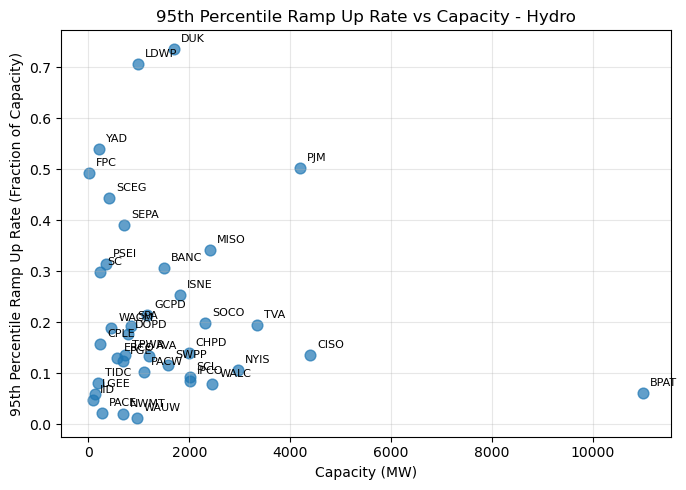


Hydro excluding pumped storage:


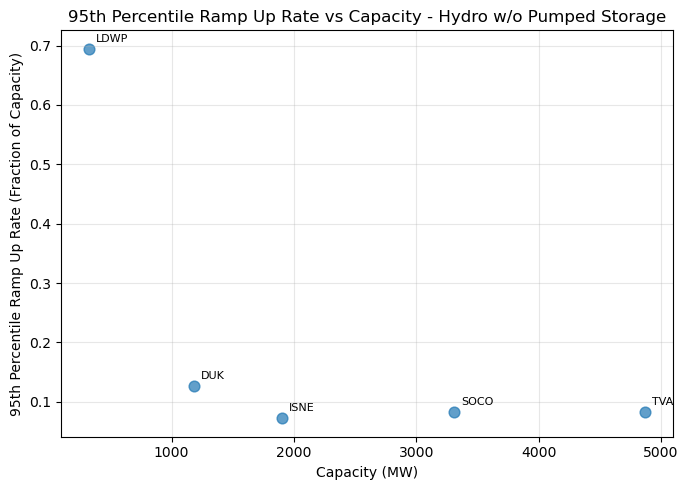

In [44]:
# Extract 95th percentile ramp up rates and merge with capacity data
def create_ramp_capacity_plot(df, energy_source, include_storage=True):
    """Create scatter plot of 95th percentile ramp up rate vs capacity"""
    
    # Calculate 95th percentile ramp up rates
    ramp_up_95 = df[df['hourly_change_fraction'] > 0].groupby('balancing_authority_code_eia')['hourly_change_fraction'].quantile(0.95)
    
    # Get average capacity by BA for plotting
    if include_storage:
        capacity_data = ba_cap.groupby('balancing_authority_code_eia')['capacity_mw'].mean()
    else:
        capacity_data = ba_cap[ba_cap['technology_description'] == 'Conventional Hydroelectric'].groupby('balancing_authority_code_eia')['capacity_mw'].mean()
    
    # Merge ramp rates with capacity data
    plot_data = pd.DataFrame({
        'ramp_up_95': ramp_up_95,
        'capacity_mw': capacity_data
    }).dropna()
    
    # Filter out BAs with ramp rates > 1 (100% of capacity)
    plot_data = plot_data[plot_data['ramp_up_95'] <= 1]
    
    # Create scatter plot
    plt.figure(figsize=(7, 5))
    plt.scatter(plot_data['capacity_mw'], plot_data['ramp_up_95'], alpha=0.7, s=60)
    
    # Add labels for points
    for ba, row in plot_data.iterrows():
        plt.annotate(ba, (row['capacity_mw'], row['ramp_up_95']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.xlabel('Capacity (MW)')
    plt.ylabel('95th Percentile Ramp Up Rate (Fraction of Capacity)')
    plt.title(f'95th Percentile Ramp Up Rate vs Capacity - {energy_source}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return plot_data

# Create plots for both datasets
print("Hydro (including pumped storage):")
hydro_plot_data = create_ramp_capacity_plot(hydro_df, 'Hydro')

print("\nHydro excluding pumped storage:")
hydro_excl_plot_data = create_ramp_capacity_plot(hydro_excluding_pumped_storage_df, 'Hydro w/o Pumped Storage', include_storage=False)

## Check LDWP ramp rates
The ramp rates for LDWP (60-70% at the 5th percentile, excluding pumped hydro) are very high. But as shown in the plots below, it seems like the reported generation data does have rapid changes.

<AxesSubplot: title={'center': 'LDWP Hydro Excluding Pumped Storage - August 2025'}, xlabel='datetime_utc'>

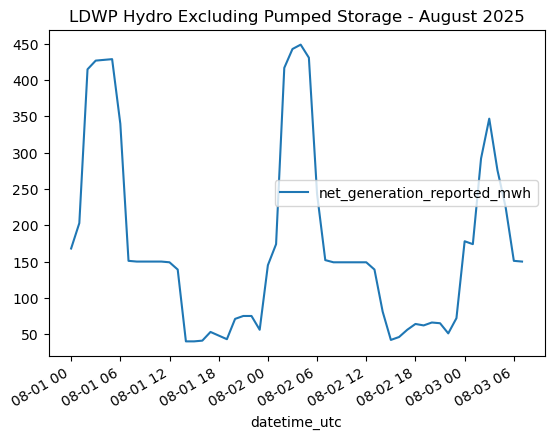

In [28]:
filtered_df.query(
    "balancing_authority_code_eia=='LDWP' and year == 2025 and datetime_utc.dt.month==8 and generation_energy_source=='hydro_excluding_pumped_storage'"
    ).plot(x='datetime_utc', y='net_generation_reported_mwh', title='LDWP Hydro Excluding Pumped Storage - August 2025')

<AxesSubplot: title={'center': 'LDWP Pumped Storage - August 2025'}, xlabel='datetime_utc'>

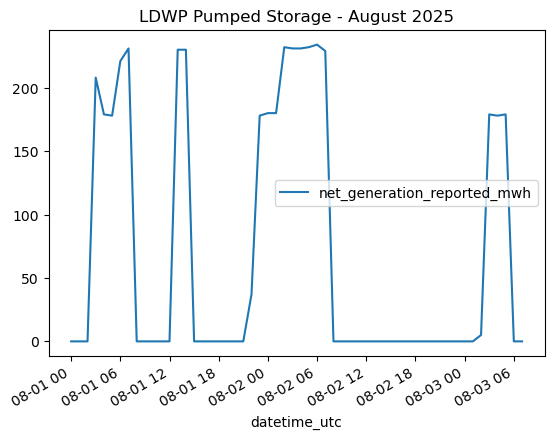

In [31]:
filtered_df.query(
    "balancing_authority_code_eia=='LDWP' and year == 2025 and datetime_utc.dt.month==8 and generation_energy_source=='pumped_storage'"
    ).plot(x='datetime_utc', y='net_generation_reported_mwh', title='LDWP Pumped Storage - August 2025')